# Определение перспективного тарифа для телеком-компании
В нашем распоряжении данные 500 пользователей «Мегалайна» — федерального оператора сотовой связи: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.
Нужно скорректировать рекламный бюджет, но для этого коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [52]:
# Импортируем библиотеку Pandas.
import pandas as pd
# Импортируем библиотеку для постраения графиков matplotlib.pyplot.
import matplotlib.pyplot as plt
# Импортируем библиотеку для постраения графиков seaborn.
import seaborn as sns
# Импортируем библиотеку для высокоуровневых математических функций numpy.
import numpy as np
import math
from scipy import stats as st
# Импортируем модуль для отключения предпреждений
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Прочитаем исходные DataFrame.
try:
    df_users = pd.read_csv('/datasets/users.csv')
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_internet = pd.read_csv('/datasets/internet.csv')
except:
    df_users = pd.read_csv('users.csv')
    df_calls = pd.read_csv('calls.csv')
    df_tariffs = pd.read_csv('tariffs.csv')
    df_messages = pd.read_csv('messages.csv')
    df_internet = pd.read_csv('internet.csv')
# Сделаем отображение всех столбцов DataFrame
pd.set_option('display.max_columns', None)

Посмотрим каждый DataFrame для понимания столбцов в каждом из них.

### Описание данных `df_users`<br>

`user_id` — уникальный идентификатор пользователя<br>
`first_name` — имя пользователя<br>
`last_name` — фамилия пользователя<br>
`age` — возраст пользователя (годы)<br>
`reg_date` — дата подключения тарифа (день, месяц, год)<br>
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)<br>
`city` — город проживания пользователя<br>
`tarif` — название тарифного плана<br>

In [3]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Описание данных `df_calls`<br>
`id` — уникальный номер звонка<br>
`call_date` — дата звонка<br>
`duration` — длительность звонка в минутах<br>
`user_id` — идентификатор пользователя, сделавшего звонок<br>

In [5]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


### Описание данных `df_tariffs`<br>

`tariff_name` — название тарифа<br>
`rub_monthly_fee` — ежемесячная абонентская плата в рублях<br>
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату<br>
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату<br>
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)<br>
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)<br>
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета<br>
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)<br>

In [7]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Описание данных `df_messages`<br>

`id` — уникальный номер сообщения<br>
`message_date` — дата сообщения<br>
`user_id` — идентификатор пользователя, отправившего сообщение<br>

In [8]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


### Описание данных `df_internet`<br>

`id` — уникальный номер сессии<br>
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)<br>
`session_date` — дата интернет-сессии<br>
`user_id` — идентификатор пользователя<br>

In [10]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


## Предобработка данных

In [12]:
# Проверим уникальность значений в столбце 'city' для исключения неточностей.
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [13]:
# В DF df_calls округлим длительность разговора до целых минут и переведем тип данных в int.
df_calls['duration'] = df_calls['duration'].apply(math.ceil)
   

In [14]:
# Сделаем столбец в df_tariffs['gb_per_month_included'], для перевода мегабайтов в гигобайты.
df_tariffs['gb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024

### Сделаем сводные таблицы Users с Calls/Messages/Internet

#### Таблица `df_users_calls`

In [15]:
df_users_calls = df_users.merge(df_calls, on='user_id', how='left')
df_users_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0


In [16]:
# Проверим наличие дубликатов методом duplicated().
df_users_calls.duplicated().sum()

0

In [17]:
# Приводим форму столбца "call_date" в понятный вид.
df_users_calls['call_date'] = pd.to_datetime(df_users_calls['call_date'], format='%Y-%m-%d')
df_users_calls['reg_date'] = pd.to_datetime(df_users_calls['reg_date'], format='%Y-%m-%d')
df_users_calls['month'] = df_users_calls['call_date'].dt.month

#### Таблица `df_users_messages`

In [18]:
df_users_messages = df_users.merge(df_messages, on='user_id', how='left')
df_users_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05


In [19]:
# Проверим наличие дубликатов методом duplicated().
df_users_messages.duplicated().sum()

0

In [20]:
# Смотрим далее. Столбец с пропусками это 'message_date'
mess_nan = df_users_messages[df_users_messages['message_date'].isna()]
len(mess_nan)

74

In [21]:
# Приводим форму столбца "message_date" в понятный вид.
df_users_messages['message_date'] = pd.to_datetime(df_users_messages['message_date'], format='%Y-%m-%d')
df_users_messages['month'] = df_users_messages['message_date'].dt.month

#### Таблица `df_users_internet`

In [22]:
df_users_internet = df_users.merge(df_internet, on='user_id', how='left')
df_users_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,Unnamed: 0,id,mb_used,session_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,1000_0,112.95,2018-11-25
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1000_1,1052.81,2018-09-07
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,1000_2,1197.26,2018-06-25
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,1000_3,550.27,2018-08-22
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,1000_4,302.56,2018-09-24


In [23]:
# Проверим наличие дубликатов методом duplicated().
df_users_internet.duplicated().sum()

0

In [24]:
# Приводим форма столбца "message_date" в понятный вид.
df_users_internet['session_date'] = pd.to_datetime(df_users_internet['session_date'], format='%Y-%m-%d')
df_users_internet['month'] = df_users_internet['session_date'].dt.month

## Расчёты и добавление результатов в таблицу

### Найдем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:

In [25]:
df_users_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,7.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,8.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,6.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,9.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,12.0


In [26]:
calls_pivot = df_users_calls.pivot_table(index= ['user_id', 'city', 'month', 'tariff'], 
                                         values= ['duration','call_date'], 
                                         aggfunc={'duration':sum, 'call_date':'count'})
calls_pivot.columns = 'calls_count','calls_sum'
calls_pivot.head()

calls_count  calls_sum
user_id city      month tariff                        
1000    Краснодар 5.0   ultra            22      159.0
                  6.0   ultra            43      172.0
                  7.0   ultra            47      340.0
                  8.0   ultra            52      408.0
                  9.0   ultra            58      466.0

### Найдем количество отправленных сообщений по месяцам для каждого пользователя.

In [27]:
df_users_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,6.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,10.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,8.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,6.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,12.0


In [28]:
messages_pivot = df_users_messages.pivot_table(index= ['user_id', 'city', 'month', 'tariff'], 
                                               values= 'id', aggfunc= 'count')
messages_pivot.columns = ['messages_count']
messages_pivot.head()

messages_count
user_id city      month tariff                
1000    Краснодар 5.0   ultra               22
                  6.0   ultra               60
                  7.0   ultra               75
                  8.0   ultra               81
                  9.0   ultra               57

### Найдем объем израсходованного интернет-трафика по месяцам для каждого пользователя.

In [29]:
df_users_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,Unnamed: 0,id,mb_used,session_date,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,1000_0,112.95,2018-11-25,11.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1.0,1000_1,1052.81,2018-09-07,9.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.0,1000_2,1197.26,2018-06-25,6.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3.0,1000_3,550.27,2018-08-22,8.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4.0,1000_4,302.56,2018-09-24,9.0


In [30]:
internet_pivot = df_users_internet.pivot_table(index= ['user_id', 'city', 'month', 'tariff'], 
                                               values= 'mb_used', aggfunc= 'sum')
internet_pivot.columns = ['mb_internet_sum']
internet_pivot.head()

mb_internet_sum
user_id city      month tariff                 
1000    Краснодар 5.0   ultra           2253.49
                  6.0   ultra          23233.77
                  7.0   ultra          14003.64
                  8.0   ultra          14055.93
                  9.0   ultra          14568.91

In [31]:
internet_pivot['gb_internet_sum'] = (internet_pivot['mb_internet_sum'] / 1024).apply(math.ceil)

In [32]:
internet_pivot.head()

mb_internet_sum  gb_internet_sum
user_id city      month tariff                                  
1000    Краснодар 5.0   ultra           2253.49                3
                  6.0   ultra          23233.77               23
                  7.0   ultra          14003.64               14
                  8.0   ultra          14055.93               14
                  9.0   ultra          14568.91               15

### Cоеденим данным таблицы в одно целое.

In [33]:
general_table = pd.concat([calls_pivot, internet_pivot, messages_pivot], sort=True, axis=1)
general_table.head()

calls_count  calls_sum  mb_internet_sum  \
user_id city      month tariff                                            
1000    Краснодар 5.0   ultra          22.0      159.0          2253.49   
                  6.0   ultra          43.0      172.0         23233.77   
                  7.0   ultra          47.0      340.0         14003.64   
                  8.0   ultra          52.0      408.0         14055.93   
                  9.0   ultra          58.0      466.0         14568.91   

                                gb_internet_sum  messages_count  
user_id city      month tariff                                   
1000    Краснодар 5.0   ultra               3.0            22.0  
                  6.0   ultra              23.0            60.0  
                  7.0   ultra              14.0            75.0  
                  8.0   ultra              14.0            81.0  
                  9.0   ultra              15.0            57.0

In [34]:
general_table = general_table.reset_index()

In [35]:
mess_count_nan = general_table[general_table['messages_count'].isna()]
len(mess_count_nan)

497

In [36]:
# Пропущеные значения в столбце messages_count предлагаю заменить на 0, что означает, смс не отправлялись.
general_table['messages_count'] = general_table['messages_count'].fillna(0)

### Найдем помесячную выручку с каждого пользователя.

In [37]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [38]:
general_table_new = general_table.merge(df_tariffs, left_on = 'tariff', right_on = 'tariff_name', how='left')
general_table_new

,user_id,city,month,tariff,calls_count,calls_sum,mb_internet_sum,gb_internet_sum,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,1000,Краснодар,5.0,ultra,22.0,159.0,2253.49,3.0,22.0,1000,30720,3000,1950,150,1,1,ultra,30.0
1,1000,Краснодар,6.0,ultra,43.0,172.0,23233.77,23.0,60.0,1000,30720,3000,1950,150,1,1,ultra,30.0
2,1000,Краснодар,7.0,ultra,47.0,340.0,14003.64,14.0,75.0,1000,30720,3000,1950,150,1,1,ultra,30.0
3,1000,Краснодар,8.0,ultra,52.0,408.0,14055.93,14.0,81.0,1000,30720,3000,1950,150,1,1,ultra,30.0
4,1000,Краснодар,9.0,ultra,58.0,466.0,14568.91,15.0,57.0,1000,30720,3000,1950,150,1,1,ultra,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,Владикавказ,10.0,smart,41.0,247.0,20579.36,21.0,42.0,50,15360,500,550,200,3,3,smart,15.0
3210,1499,Пермь,9.0,smart,9.0,70.0,1845.75,2.0,11.0,50,15360,500,550,200,3,3,smart,15.0
3211,1499,Пермь,10.0,smart,68.0,449.0,17788.51,18.0,48.0,50,15360,500,550,200,3,3,smart,15.0
3212,1499,Пермь,11.0,smart,74.0,612.0,17963.31,18.0,59.0,50,15360,500,550,200,3,3,smart,15.0


In [39]:
def revenue(row):
    call = 0
    mess = 0
    inte = 0
    total = 0
    if row['tariff'] == 'ultra':
        if row['calls_sum'] - row['minutes_included'] > 0:
            call += (row['calls_sum'] - row['minutes_included']) * row['rub_per_minute']

    if row['tariff'] == 'ultra':
        if row['messages_count'] - row['messages_included'] > 0:
            mess += (row['messages_count'] - row['messages_included']) * row['rub_per_message']

    if row['tariff'] == 'ultra':
        if row['gb_internet_sum'] - row['gb_per_month_included'] > 0:
            inte += (row['gb_internet_sum'] - row['gb_per_month_included']) * row['rub_per_gb']
            
    if row['tariff'] == 'smart':
        if row['calls_sum'] - row['minutes_included'] > 0:
            call += (row['calls_sum'] - row['minutes_included']) * row['rub_per_minute']

    if row['tariff'] == 'smart':
        if row['messages_count'] - row['messages_included'] > 0:
            mess += (row['messages_count'] - row['messages_included']) * row['rub_per_message']

    if row['tariff'] == 'smart':
        if row['gb_internet_sum'] - row['gb_per_month_included'] > 0:
            inte += (row['gb_internet_sum'] - row['gb_per_month_included']) * row['rub_per_gb']
            
    if row['tariff'] == 'smart':
        total = call + mess + inte + row['rub_monthly_fee']
    else:
        total = call + mess + inte + row['rub_monthly_fee']
    
    return total

general_table_new['revenue_per_month'] = general_table_new.apply(revenue, axis = 1)

In [40]:
general_table_new.head()

,user_id,city,month,tariff,calls_count,calls_sum,mb_internet_sum,gb_internet_sum,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included,revenue_per_month
0,1000,Краснодар,5.0,ultra,22.0,159.0,2253.49,3.0,22.0,1000,30720,3000,1950,150,1,1,ultra,30.0,1950.0
1,1000,Краснодар,6.0,ultra,43.0,172.0,23233.77,23.0,60.0,1000,30720,3000,1950,150,1,1,ultra,30.0,1950.0
2,1000,Краснодар,7.0,ultra,47.0,340.0,14003.64,14.0,75.0,1000,30720,3000,1950,150,1,1,ultra,30.0,1950.0
3,1000,Краснодар,8.0,ultra,52.0,408.0,14055.93,14.0,81.0,1000,30720,3000,1950,150,1,1,ultra,30.0,1950.0
4,1000,Краснодар,9.0,ultra,58.0,466.0,14568.91,15.0,57.0,1000,30720,3000,1950,150,1,1,ultra,30.0,1950.0


## Исследовательский анализ данных

Нам нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы. Опишем распределения.

In [41]:
# Разделим таблицу на две, относительно каждого тарифа.
tariff_ultra = general_table_new.query('tariff == "ultra"')
tariff_smart = general_table_new.query('tariff == "smart"')

### Иследуем тариф Ultra

In [42]:
# Найдем сколько в среднем приносит тариф Ultra
avg_sum_ultra = (tariff_ultra['revenue_per_month']).sum() / len(tariff_ultra['revenue_per_month'])
avg_sum_ultra

2070.1522842639592

In [43]:
# Найдем среднее количества минут разговора по месяцам в тарифе "Ultra"
avg_call_ultra = tariff_ultra.pivot_table(index='month', values=['calls_sum'], aggfunc='mean')
avg_call_ultra.sort_values(by= 'month').reset_index()

,month,calls_sum
0,1.0,428.111111
1,2.0,297.125000
2,3.0,489.648649
3,4.0,475.301887
4,5.0,534.250000
5,6.0,497.469136
6,7.0,564.397727
7,8.0,530.611650
8,9.0,558.882883
9,10.0,581.728814


Text(0, 0.5, 'Количество минут')

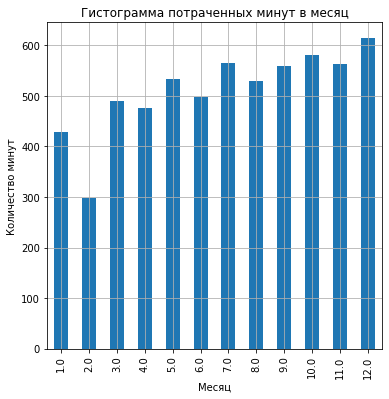

In [44]:
avg_call_ultra['calls_sum'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных минут в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество минут')

In [46]:
avg_call_ultra = avg_call_ultra.reset_index()

In [45]:
# Найдем количество лимита минут разговора по месяцам в тарифе "Ultra"
limit_call_ultra = tariff_ultra.pivot_table(index='month', values=['minutes_included'], aggfunc='sum')
limit_call_ultra.sort_values(by= 'month').reset_index()

,month,minutes_included
0,1.0,27000
1,2.0,72000
2,3.0,111000
3,4.0,165000
4,5.0,201000
5,6.0,252000
6,7.0,273000
7,8.0,321000
8,9.0,345000
9,10.0,369000


In [46]:
# Найдем количество потраченных минут разговора по месяцам в тарифе "Ultra"
use_call_ultra = tariff_ultra.pivot_table(index='month', values=['calls_sum'], aggfunc='sum')
use_call_ultra.sort_values(by= 'month').reset_index()

,month,calls_sum
0,1.0,3853.0
1,2.0,7131.0
2,3.0,18117.0
3,4.0,25191.0
4,5.0,34192.0
5,6.0,40295.0
6,7.0,49667.0
7,8.0,54653.0
8,9.0,62036.0
9,10.0,68644.0


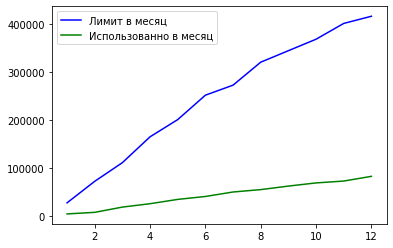

In [47]:
# Построим график, который показывает, сколько у пользователей лимита и сколько они тратят
plt.plot(limit_call_ultra, 'b-', use_call_ultra, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [48]:
# Найдем сколько минут требуется пользователям тарифа Ultra в среднем в месяц
avg_call_ultra_month = (avg_call_ultra['calls_sum']).sum() / len(avg_call_ultra['calls_sum'])
avg_call_ultra_month

511.23471423122083

In [53]:
# Найдем дисперсию количества минут разговора
call_ultra_variance = np.var(tariff_ultra)['calls_sum']
call_ultra_variance

94104.36117385981

In [54]:
# Найдем стандартное отклонение минут разговора
call_ultra_std = np.std(tariff_ultra)['calls_sum']
call_ultra_std

306.7643414314314

In [55]:
# Найдем среднее количество отправленных смс по месяцам в тарифе "Ultra"
avg_mess_ultra = tariff_ultra.pivot_table(index='month', values=['messages_count'], aggfunc='mean')
avg_mess_ultra.sort_values(by= 'month').reset_index()

,month,messages_count
0,1.0,33.777778
1,2.0,21.958333
2,3.0,32.297297
3,4.0,31.563636
4,5.0,37.850746
5,6.0,41.726190
6,7.0,49.846154
7,8.0,48.439252
8,9.0,52.286957
9,10.0,58.430894


In [56]:
avg_mess_ultra = avg_mess_ultra.reset_index()

In [57]:
# Найдем количество лимита смс по месяцам в тарифе "Ultra"
limit_mess_ultra = tariff_ultra.pivot_table(index='month', values=['messages_included'], aggfunc='sum')
limit_mess_ultra.sort_values(by= 'month').reset_index()

,month,messages_included
0,1.0,9000
1,2.0,24000
2,3.0,37000
3,4.0,55000
4,5.0,67000
5,6.0,84000
6,7.0,91000
7,8.0,107000
8,9.0,115000
9,10.0,123000


In [58]:
# Найдем количество потраченных смс по месяцам в тарифе "Ultra"
use_mess_ultra = tariff_ultra.pivot_table(index='month', values=['messages_count'], aggfunc='sum')
use_mess_ultra.sort_values(by= 'month').reset_index()

,month,messages_count
0,1.0,304.0
1,2.0,527.0
2,3.0,1195.0
3,4.0,1736.0
4,5.0,2536.0
5,6.0,3505.0
6,7.0,4536.0
7,8.0,5183.0
8,9.0,6013.0
9,10.0,7187.0


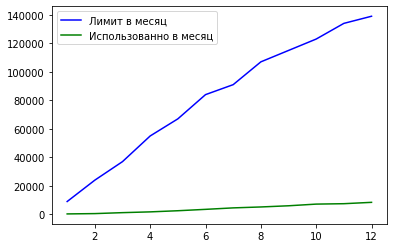

In [59]:
# Построим график, который показывает, сколько у пользователей лимита и сколько они тратят
plt.plot(limit_mess_ultra, 'b-', use_mess_ultra, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [60]:
# Найдем сколько сообщений требуется пользователям тарифа Ultra в среднем в месяц
avg_mess_ultra_month = (avg_mess_ultra['messages_count']).sum() / len(avg_mess_ultra['messages_count'])
avg_mess_ultra_month

43.71498284147191

In [61]:
# Найдем дисперсию количества отправленых смс
mess_ultra_variance = np.var(tariff_ultra)['messages_count']
mess_ultra_variance

2282.9460753948824

In [62]:
# Найдем стандартное отклонение отправленых смс
mess_ultra_std = np.std(tariff_ultra)['messages_count']
mess_ultra_std

47.78018496610161

Text(0, 0.5, 'Количество смс')

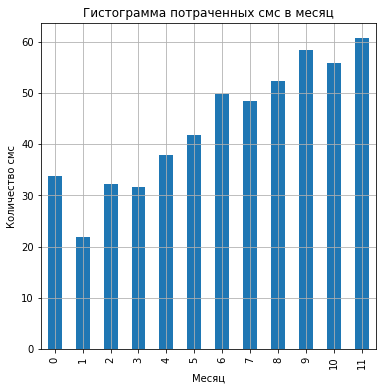

In [63]:
avg_mess_ultra['messages_count'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных смс в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество смс')

In [64]:
# Найдем среднее количество использованного интернет трафика по месяцам в тарифе "Ultra"
avg_inte_ultra = tariff_ultra.pivot_table(index='month', values=['gb_internet_sum'], aggfunc='mean')
avg_inte_ultra.sort_values(by= 'month').reset_index()

,month,gb_internet_sum
0,1.0,13.222222
1,2.0,13.090909
2,3.0,17.648649
3,4.0,16.963636
4,5.0,19.666667
5,6.0,19.168675
6,7.0,20.733333
7,8.0,19.783019
8,9.0,19.412281
9,10.0,20.229508


In [65]:
avg_inte_ultra = avg_inte_ultra.reset_index()

In [66]:
# Найдем количество лимита gb по месяцам в тарифе "Ultra"
limit_gb_ultra = tariff_ultra.pivot_table(index='month', values=['gb_per_month_included'], aggfunc='sum')
limit_gb_ultra.sort_values(by= 'month').reset_index()

,month,gb_per_month_included
0,1.0,270.0
1,2.0,720.0
2,3.0,1110.0
3,4.0,1650.0
4,5.0,2010.0
5,6.0,2520.0
6,7.0,2730.0
7,8.0,3210.0
8,9.0,3450.0
9,10.0,3690.0


In [67]:
# Найдем количество потраченных gb по месяцам в тарифе "Ultra"
use_gb_ultra = tariff_ultra.pivot_table(index='month', values=['gb_internet_sum'], aggfunc='sum')
use_gb_ultra.sort_values(by= 'month').reset_index()

,month,gb_internet_sum
0,1.0,119.0
1,2.0,288.0
2,3.0,653.0
3,4.0,933.0
4,5.0,1298.0
5,6.0,1591.0
6,7.0,1866.0
7,8.0,2097.0
8,9.0,2213.0
9,10.0,2468.0


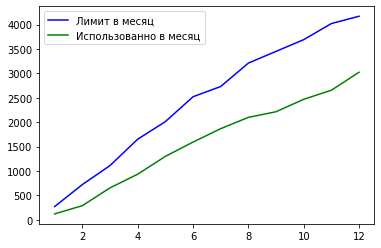

In [68]:
# Построим график, который показывает, сколько у пользователей лимита и сколько они тратят
plt.plot(limit_gb_ultra, 'b-', use_gb_ultra, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [69]:
# Найдем сколько GB требуется пользователям тарифа Ultra в среднем в месяц
avg_inte_ultra_month = (avg_inte_ultra['gb_internet_sum']).sum() / len(avg_inte_ultra['gb_internet_sum'])
avg_inte_ultra_month

18.481028061107875

In [70]:
# Найдем дисперсию интернет трафика
inte_ultra_variance = np.var(tariff_ultra)['gb_internet_sum']
inte_ultra_variance

94.05017330703484

In [71]:
# Найдем стандартное интернет трафика
inte_ultra_std = np.std(tariff_ultra)['gb_internet_sum']
inte_ultra_std

9.697946860394463

Text(0, 0.5, 'Количество ГБ')

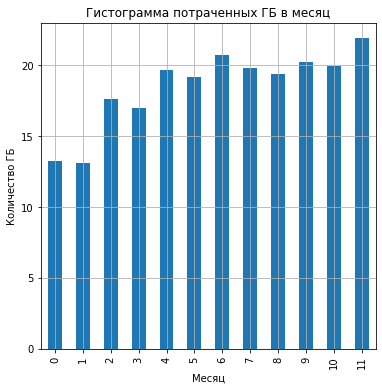

In [72]:
avg_inte_ultra['gb_internet_sum'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных ГБ в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество ГБ')

### Иследуем тариф Smart

In [73]:
# Найдем сколько в среднем приносит тариф Ultra
avg_sum_smart = (tariff_smart['revenue_per_month']).sum() / len(tariff_smart['revenue_per_month'])
avg_sum_smart

1289.9735307312696

In [74]:
# Найдем среднее количества минут разговора по месяцам в тарифе "Smart"
avg_call_smart = tariff_smart.pivot_table(index='month', values=['calls_sum'], aggfunc='mean')
avg_call_smart.sort_values(by= 'month').reset_index()

,month,calls_sum
0,1.0,203.852941
1,2.0,298.689655
2,3.0,390.051948
3,4.0,367.133929
4,5.0,387.361702
5,6.0,398.067485
6,7.0,408.353234
7,8.0,423.269231
8,9.0,430.266409
9,10.0,427.590444


In [75]:
avg_call_smart = avg_call_smart.reset_index()

In [76]:
# Найдем количество лимита минут разговора по месяцам в тарифе "Smart"
limit_call_smart = tariff_smart.pivot_table(index='month', values=['minutes_included'], aggfunc='sum')
limit_call_smart.sort_values(by= 'month').reset_index()

,month,minutes_included
0,1.0,17000
1,2.0,29000
2,3.0,38500
3,4.0,56000
4,5.0,70500
5,6.0,82000
6,7.0,100500
7,8.0,117500
8,9.0,130000
9,10.0,147000


In [77]:
# Найдем количество потраченных минут разговора по месяцам в тарифе "Smart"
use_call_smart = tariff_smart.pivot_table(index='month', values=['calls_sum'], aggfunc='sum')
use_call_smart.sort_values(by= 'month').reset_index()

,month,calls_sum
0,1.0,6931.0
1,2.0,17324.0
2,3.0,30034.0
3,4.0,41119.0
4,5.0,54618.0
5,6.0,64885.0
6,7.0,82079.0
7,8.0,99045.0
8,9.0,111439.0
9,10.0,125284.0


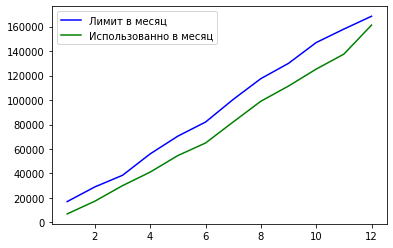

In [78]:
# Найдем количество потраченных смс по месяцам в тарифе "Smart"
plt.plot(limit_call_smart, 'b-', use_call_smart, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [79]:
# Найдем сколько минут требуется пользователям тарифа Smart в среднем в месяц
avg_call_smart_month = (avg_call_smart['calls_sum']).sum() / len(avg_call_smart['calls_sum'])
avg_call_smart_month

387.605809617519

In [80]:
# Найдем дисперсию количества минут разговора
call_smart_variance = np.var(tariff_smart)['calls_sum']
call_smart_variance

35828.06530953033

In [81]:
# Найдем стандартное отклонение минут разговора
call_smart_std = np.std(tariff_smart)['calls_sum']
call_smart_std

189.2830296395594

Text(0, 0.5, 'Количество минут')

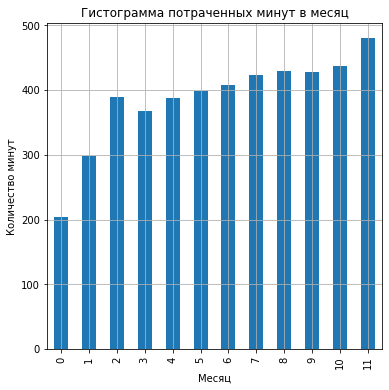

In [80]:
avg_call_smart['calls_sum'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных минут в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество минут')

In [82]:
# Найдем среднее количество отправленных смс по месяцам в тарифе "Smart"
avg_mess_smart = tariff_smart.pivot_table(index='month', values=['messages_count'], aggfunc='mean')
avg_mess_smart.sort_values(by= 'month').reset_index()

,month,messages_count
0,1.0,18.235294
1,2.0,24.086207
2,3.0,31.857143
3,4.0,30.741071
4,5.0,33.773050
5,6.0,33.402439
6,7.0,33.751244
7,8.0,33.638298
8,9.0,33.638462
9,10.0,33.765306


In [83]:
avg_mess_smart = avg_mess_smart.reset_index()

In [84]:
# Найдем количество лимита смс по месяцам в тарифе "Smart"
limit_mess_smart = tariff_smart.pivot_table(index='month', values=['messages_included'], aggfunc='sum')
limit_mess_smart.sort_values(by= 'month').reset_index()

,month,messages_included
0,1.0,1700
1,2.0,2900
2,3.0,3850
3,4.0,5600
4,5.0,7050
5,6.0,8200
6,7.0,10050
7,8.0,11750
8,9.0,13000
9,10.0,14700


In [85]:
# Найдем количество потраченных смс по месяцам в тарифе "Smart"
use_mess_smart = tariff_smart.pivot_table(index='month', values=['messages_count'], aggfunc='sum')
use_mess_smart.sort_values(by= 'month').reset_index()

,month,messages_count
0,1.0,620.0
1,2.0,1397.0
2,3.0,2453.0
3,4.0,3443.0
4,5.0,4762.0
5,6.0,5478.0
6,7.0,6784.0
7,8.0,7905.0
8,9.0,8746.0
9,10.0,9927.0


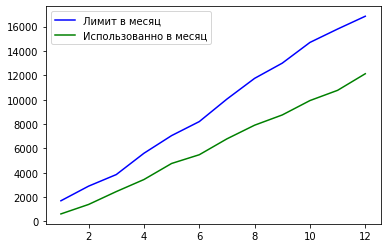

In [86]:
# Найдем количество потраченных смс по месяцам в тарифе "Smart"
plt.plot(limit_mess_smart, 'b-', use_mess_smart, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [87]:
# Найдем сколько сообщений требуется пользователям тарифа Smart в среднем в месяц
avg_mess_smart_month = (avg_mess_smart['messages_count']).sum() / len(avg_mess_smart['messages_count'])
avg_mess_smart_month

31.413210661085547

In [88]:
# Найдем дисперсию количества отправленых смс
mess_smart_variance = np.var(tariff_smart)['messages_count']
mess_smart_variance

796.455482917076

In [89]:
# Найдем стандартное отклонение отправленых смс
mess_smart_std = np.std(tariff_smart)['messages_count']
mess_smart_std

28.221542886898938

Text(0, 0.5, 'Количество смс')

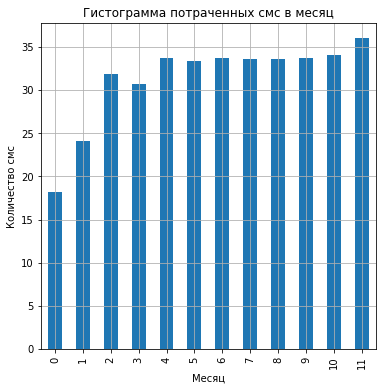

In [90]:
avg_mess_smart['messages_count'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных смс в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество смс')

In [91]:
# Найдем среднее количество использованного интернет трафика по месяцам в тарифе "Smart"
avg_inte_smart = tariff_smart.pivot_table(index='month', values=['gb_internet_sum'], aggfunc='mean')
avg_inte_smart.sort_values(by= 'month').reset_index()

,month,gb_internet_sum
0,1.0,8.735294
1,2.0,11.844828
2,3.0,15.233766
3,4.0,13.625000
4,5.0,15.907801
5,6.0,15.951220
6,7.0,15.875622
7,8.0,16.807692
8,9.0,16.392308
9,10.0,16.880952


In [92]:
avg_inte_smart = avg_inte_smart.reset_index()

In [93]:
# Найдем количество лимита gb по месяцам в тарифе "Smart"
limit_gb_smart = tariff_smart.pivot_table(index='month', values=['gb_per_month_included'], aggfunc='sum')
limit_gb_smart.sort_values(by= 'month').reset_index()

,month,gb_per_month_included
0,1.0,510.0
1,2.0,870.0
2,3.0,1155.0
3,4.0,1680.0
4,5.0,2115.0
5,6.0,2460.0
6,7.0,3015.0
7,8.0,3525.0
8,9.0,3900.0
9,10.0,4410.0


In [94]:
# Найдем количество потраченных gb по месяцам в тарифе "Smart"
use_gb_smart = tariff_smart.pivot_table(index='month', values=['gb_internet_sum'], aggfunc='sum')
use_gb_smart.sort_values(by= 'month').reset_index()

,month,gb_internet_sum
0,1.0,297.0
1,2.0,687.0
2,3.0,1173.0
3,4.0,1526.0
4,5.0,2243.0
5,6.0,2616.0
6,7.0,3191.0
7,8.0,3933.0
8,9.0,4262.0
9,10.0,4963.0


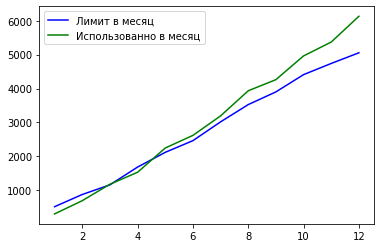

In [95]:
# Найдем количество потраченных смс по месяцам в тарифе "Smart"
plt.plot(limit_gb_smart, 'b-', use_gb_smart, 'g-')
plt.legend(['Лимит в месяц','Использованно в месяц'])

In [96]:
# Найдем сколько GB требуется пользователям тарифа Smart в среднем в месяц
avg_inte_smart_month = (avg_inte_smart['gb_internet_sum']).sum() / len(avg_inte_smart['gb_internet_sum'])
avg_inte_smart_month

15.204688629598747

In [97]:
# Найдем дисперсию количества использованного интернет трафика
inte_smart_variance = np.var(tariff_smart)['gb_internet_sum']
inte_smart_variance

32.908978554322495

In [98]:
# Найдем стандартное отклонение использованного интернет трафика
inte_smart_std = np.std(tariff_smart)['gb_internet_sum']
inte_smart_std

5.73663477609674

Text(0, 0.5, 'Количество ГБ')

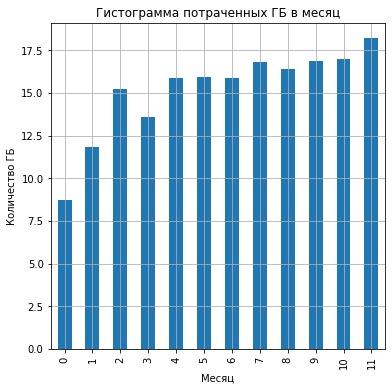

In [99]:
avg_inte_smart['gb_internet_sum'].plot(grid=True, figsize=(6, 6), kind= 'bar')
plt.title('Гистограмма потраченных ГБ в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество ГБ')

### Графики однотипных услуг

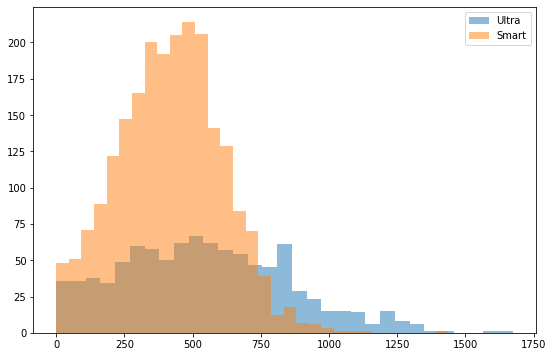

In [100]:
# Построим два графика по сумме звонков для тарифа 'Ultra' и 'Smart' 
fig, ax = plt.subplots(figsize=(9, 6)) # создание объектов фигуры и оси
# Вызываем метод hist для построения гистограммы
ax.hist(general_table_new.query("tariff=='ultra'")['calls_sum'], bins=31, alpha=0.5, label='Ultra')
ax.hist(general_table_new.query("tariff=='smart'")['calls_sum'], bins=31, alpha=0.5, label='Smart')
ax.legend();

Вывод: Мы видим, что в тарифе Smart довольно много пользователей выходят за свой лимит в 500 минут, а вот пользователи тарифа Ultra не тратят свой лимит в 3000 минут.

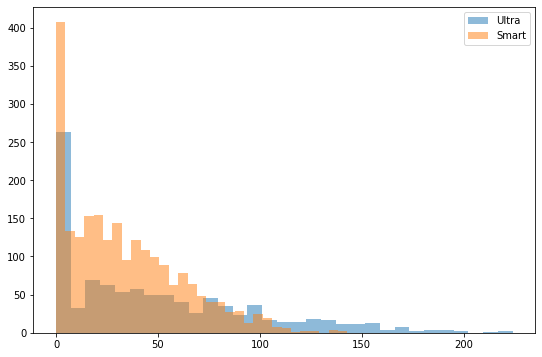

In [101]:
# Построим два графика по сумме смс для тарифа 'Ultra' и 'Smart' 
fig, ax = plt.subplots(figsize=(9, 6)) # создание объектов фигуры и оси
# Вызываем метод hist для построения гистограммы
ax.hist(general_table_new.query("tariff=='ultra'")['messages_count'], bins=31, alpha=0.5, label='Ultra')
ax.hist(general_table_new.query("tariff=='smart'")['messages_count'], bins=31, alpha=0.5, label='Smart')

ax.legend();

Вывод: Мы видим, что пользователи тарифа Smart выходят за свой лимит в 50 смс, а вот пользователи тарифа Ultra снова не тратят свой лимит в 1000 смс.

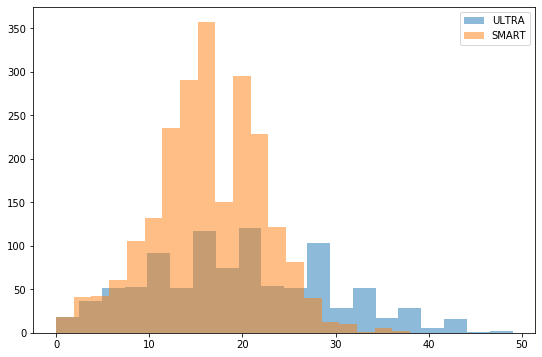

In [101]:
# Построим два графика по сумме GB для тарифа 'Ultra' и 'Smart' 
fig, ax = plt.subplots(figsize=(9, 6))   # создание объектов фигуры и оси
for t in general_table_new['tariff'].unique():
    series = general_table_new[general_table_new['tariff']==t]['gb_internet_sum']
    ax.hist(series, bins=20, alpha=0.5, label=t.upper())
ax.legend();

Вывод: Мы можем наблюдать, что много пользователей тарифа Smart выходят за свой лимит в 15 гб, и даже пользователи тарифа Ultra используют больше своего лимита в 30 гб, но их не очень много.

### Иследуем общий доход относительно тарифов

In [102]:
# Найдем количесво каждого тарифа в выборке и умножим на их среднюю доходность. Тем самым определим какой тариф приносит больше.
ultra = len(tariff_ultra) * avg_sum_ultra
print(ultra)
smart = len(tariff_smart) * avg_sum_smart
print(smart)
share_sum_ultra = ultra / (smart + ultra)
print(share_sum_ultra)
share_sum_smart = smart / (smart + ultra)
print(share_sum_smart)

2039099.9999999998
2875351.0
0.41491918425883173
0.5850808157411682


In [103]:
share_ultra = len(tariff_ultra) / len(general_table)
print(share_ultra)
share_smart = len(tariff_smart) / len(general_table)
print(share_smart)

0.30647168637212197
0.693528313627878


In [104]:
general_table_new.groupby('tariff').agg({'revenue_per_month': 'sum'})\
    .assign(share_of_revenue=lambda row: row['revenue_per_month'] / row['revenue_per_month'].sum())

,revenue_per_month,share_of_revenue
tariff,,
smart,2875351.0,0.585081
ultra,2039100.0,0.414919


## Проверка гипотиз

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Мы формилируем нулевую гипотезу H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.<br>
Формилируем альтернативную гипотезу H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.<br>
Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind (array1, array2,equal_var)`

In [105]:
alpha = .01 # критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    tariff_ultra['revenue_per_month'], 
    tariff_smart['revenue_per_month'],
    equal_var= False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


#### Вывод

Мы получили значение p-значение:  4.26e-250, которое значительно ниже заданного alpha. Получается, средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. И у нас достаточно фактов для отвержения нулевой гипотезы H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Мы формилируем нулевую гипотезу H₀ - Cредняя выручка пользователей из Москвы и выручки пользователей из других регионов равны.<br>
Формилируем альтернативную гипотезу H₁ - Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.<br>
Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind (array1, array2,equal_var)`

In [106]:
# Разделим таблицу на две, относительно региона. 1 таблица только Москва, 2 таблица все остальные регионы.
mos_region = general_table_new.query('city == "Москва"')
others_region = general_table_new.query('city != "Москва"')

In [107]:
alpha = .01 # критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    mos_region['revenue_per_month'], 
    others_region['revenue_per_month'],
    equal_var= False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Мы получили значение p-значение:  0.52, которое значительно выше заданного alpha. Это значит, что 52% значений попдают в наш диапазон. Получается, что средняя выручка пользователей из Москвы, относительно других регионов практически не отличается. И у нас нет достаточно фактов для отвержения нулевой гипотезы H₀ - Cредняя выручка пользователей из Москвы и выручки пользователей из других регионов равны.

## Общий вывод

Анализируя датасет:
- Мы импортировали библиотеки (pandas, matplotlib.pyplot, seaborn, numpy, math, stats)
- Прочли исхдные DF.  И добавили описание данных.
- Проверили данные DF на наличие пропущенных значений.
- Пропуски были только в df_users[churn_date], которые мы оставили.
- Столбец df_users[city] был проверен на неявные дубликаты.
- Был преобразован столбец df[first_day_exposition] в читаемый формат.	

Переходя к итогам исследования:
1. Столбец df_tariffs[mb_per_month_included] был пересчитан в GB и добавлен новый столбец df_tariffs['gb_per_month_included'].
2. Далее столбец df_calls['duration'] мы окргулили в большую сторону используя метод math.ceil
3. Были сделаны сводные таблицы (df_users_calls, df_users_messages, df_users_internet) методом merge()
4. Далее мы методом .pivot_table() расчитали количесво звонков и сумму потраченых минут, количесво отправленых смс и ГБ потраченного трафика для каждого пользователя в каждом месяце.
5. Создали одну таблицу general_table в которой совместили все предыдущие методом pd.concat()
6. Нашли выручку с каждого пользователя в месяц. Для этого создали функцию revenue и применили ко всем строкам DF добавив столбец general_table['revenue_per_month']
7. Следом сделали два среза по каждому тарифу.
8. Исследовали каждый тариф в отдельности на среднюю выручку с пользователя avg_sum_ultra, среднее количесво используемых минут avg_call_ultra_month, среднее количесво используемого интернет трафика avg_inte_ultra, дисперсию и стандартное отклонение этих параметров.
9. Нашли выручку каждого тарифа в выборке.
10. Проверили две гипотизы.

Можно сделать такие выводы:
1. Тарифный план Ultra приносит компании выручку(2039099 рублей за 2018 год это 41% от всей выручки), чем тариф Smart (2875351 рублей за 2018 год это 59% от всей выручки) несмотря на то, Smart в среднем дешевле, но им пользуется больше людей (69%)
2. Гипотиза "Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" можно считать правдивой. Так проведя ислледование это подвердилось
3. Гипотиза "Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов." можно считать ложной, так как иследования показали, что отличий Москвы от регионов нет или оно незначительное.